<a href="https://colab.research.google.com/github/Keerthana02122001/Twitter_sentiment_analysis/blob/master/Twitter_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keerthanakallur","key":"585a7f09e9d3e689044a6b76ec6d02cb"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           7430        226  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27           1437         35  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           4828        107  1.0              
thedevastator/how-much-sleep-do-americans-really-get        

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

 95% 77.0M/80.9M [00:02<00:00, 40.9MB/s]
100% 80.9M/80.9M [00:02<00:00, 30.6MB/s]


In [ ]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 48 kB/s 
     |████████████████████████████████| 199 kB 72.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=1880e709e9a03d6546f06e4c03408dd4f478bcc392bfd7c271e9bb34cfa62abc
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as func
from pyspark.sql.types import StringType,FloatType
import nltk

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Twitter').getOrCreate()
spark

# Loading the data in Spark Dataframe

In [ ]:
df = spark.read.csv("/content/training.1600000.processed.noemoticon.csv",inferSchema=True)

In [ ]:
df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



Renaming the columns

In [ ]:
df = df.withColumnRenamed('_c0','target').withColumnRenamed('_c1','id').withColumnRenamed('_c2','date')\
  .withColumnRenamed('_c3','flag').withColumnRenamed('_c4','user').withColumnRenamed('_c5','text')
df.show(5)

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



Checking the Schema

In [ ]:
df.printSchema()

# Inspect and Preprocessing the Dataset

In [ ]:
df.head(5)

[Row(target=0, id=1467810369, date='Mon Apr 06 22:19:45 PDT 2009', flag='NO_QUERY', user='_TheSpecialOne_', text="@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"),
 Row(target=0, id=1467810672, date='Mon Apr 06 22:19:49 PDT 2009', flag='NO_QUERY', user='scotthamilton', text="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 Row(target=0, id=1467810917, date='Mon Apr 06 22:19:53 PDT 2009', flag='NO_QUERY', user='mattycus', text='@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'),
 Row(target=0, id=1467811184, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='ElleCTF', text='my whole body feels itchy and like its on fire '),
 Row(target=0, id=1467811193, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='Karoli', text="@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because

In [ ]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1600000 rows and  6 columns in the dataset.


Check for missing values!!

In [ ]:
df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,target,id,date,flag,user,text
0,0,0,0,0,0,0


Check for duplicates!!

In [ ]:
df = df.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {df.count()}")

Number of rows in the dataframe after dropping the duplicates: 1600000


Check types of columns!!

In [ ]:
df.dtypes

[('target', 'int'),
 ('id', 'bigint'),
 ('date', 'string'),
 ('flag', 'string'),
 ('user', 'string'),
 ('text', 'string')]

Summary of the Dataframe

In [ ]:
#df.summary().show(5)
#df.describe().show(5)

We only need the target and the text column for sentiment analyses, that's why dropping the rest of the columns

In [ ]:
drop_cols= ("id","date","flag","user")
df = df.drop(*drop_cols)

In [ ]:
df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
df.show(5, truncate = False)

+------+----------------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                                        |
+------+----------------------------------------------------------------------------------------------------------------------------+
|0     |At work                                                                                                                     |
|0     |@astewart87 oh my gosh that made me emotional haha idk why!!! i dont want to get old                                        |
|0     |i need new glasses...mines is hangnon 1 arm                                                                                 |
|0     |Getting changed in the hopes that, that means we can go to the store now!  Poor cat is out of food...oops.                  |
|0     |really now, time for sleep. dreaming of my city, more 

In [ ]:
df.select("target").distinct().show()

+------+
|target|
+------+
|     4|
|     0|
+------+



There are only two distinct values in target column. O for "Negative" and 4 for "Positive" according to data description. Let's change the value of Positive from 4 to 1.

In [ ]:
df.createOrReplaceTempView('temp')
df = spark.sql('SELECT CASE target WHEN 4 THEN 1.0  ELSE 0 END AS label, text FROM temp')
df.show(5, truncate = False)

+-----+----------------------------------------------------------------------------------------------------------------------------+
|label|text                                                                                                                        |
+-----+----------------------------------------------------------------------------------------------------------------------------+
|0.0  |At work                                                                                                                     |
|0.0  |@astewart87 oh my gosh that made me emotional haha idk why!!! i dont want to get old                                        |
|0.0  |i need new glasses...mines is hangnon 1 arm                                                                                 |
|0.0  |Getting changed in the hopes that, that means we can go to the store now!  Poor cat is out of food...oops.                  |
|0.0  |really now, time for sleep. dreaming of my city, more tattoos,

In [ ]:
df.tail(5)

[Row(label=Decimal('1.0'), text='Installing office to my little netbook, going to do some work at a friends house in a short while. '),
 Row(label=Decimal('1.0'), text='man.. Ab got work.. ahhh!!! but later imma shop till i drop!! '),
 Row(label=Decimal('1.0'), text="@paupaula I'm joining The SPectrum maybe. Idk... But yeah I'm dedicating myself to my studies too  How? Idk."),
 Row(label=Decimal('1.0'), text='Friend over  My god! 300th Update!!'),
 Row(label=Decimal('1.0'), text='TIME MAG ONLINE is very interesting. Watching videos this morning. Enjoying free content... while it lasts. ')]

In [ ]:
df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|800000|
|  1.0|800000|
+-----+------+



### **Text Preprocessing**
Remove stopwords, punctuations, links, and stem the data

In [ ]:
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
clean_text = func.udf(lambda x: preprocess(x), StringType())
df = df.withColumn('text_cleaned',clean_text(func.col("text")))

CPU times: user 8.98 ms, sys: 398 µs, total: 9.38 ms
Wall time: 55.3 ms


In [ ]:
df.show()

+-----+--------------------+--------------------+
|label|                text|        text_cleaned|
+-----+--------------------+--------------------+
|  0.0|            At work |                work|
|  0.0|@astewart87 oh my...|oh gosh made emot...|
|  0.0|i need new glasse...|need new glasses ...|
|  0.0|Getting changed i...|getting changed h...|
|  0.0|really now, time ...|really time sleep...|
|  0.0|pfff i want to go...|pfff want go back...|
|  0.0|Currently watchin...|currently watchin...|
|  0.0|What a bad day! N...|bad day need comf...|
|  0.0|Tried to install ...|tried install twi...|
|  0.0|Having casual, un...|casual unprotecte...|
|  0.0|Good morning worl...|good morning worl...|
|  0.0|@pmarnandus re: d...|daily gossip well...|
|  0.0|Someone somewhere...|someone somewhere...|
|  0.0|@weblivz What a b...|boot would demand...|
|  0.0|@jobeaz damn, sor...|damn sorry missed...|
|  0.0|@klariza that's a...|awesome love stuf...|
|  0.0|my tv husbands ri...|tv husbands rick ...|


# Displaying Word Cloud

In [ ]:
! pip install WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from wordcloud import WordCloud

In [ ]:
pandas_df = df.toPandas()
pandas_df.head()

,label,text,text_cleaned
0,0.0,At work,work
1,0.0,@astewart87 oh my gosh that made me emotional ...,oh gosh made emotional haha idk dont want get old
2,0.0,i need new glasses...mines is hangnon 1 arm,need new glasses mines hangnon 1 arm
3,0.0,"Getting changed in the hopes that, that means ...",getting changed hopes means go store poor cat ...
4,0.0,"really now, time for sleep. dreaming of my cit...",really time sleep dreaming city tattoos great ...


## Positive Sentiments Word Cloud

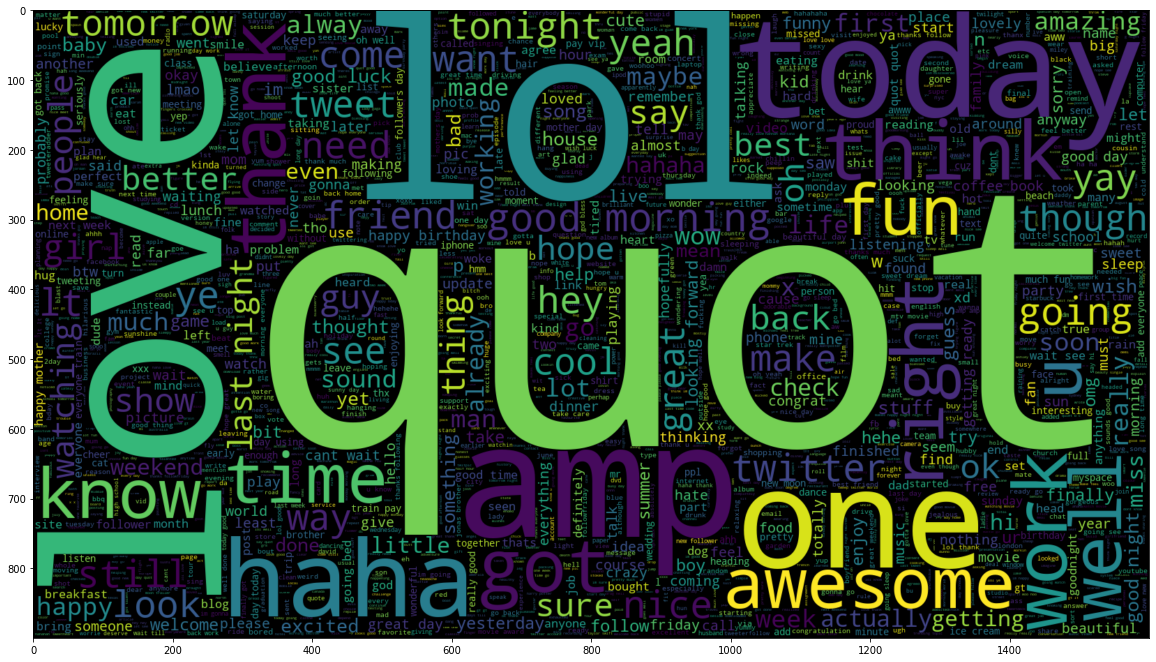

In [ ]:
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==1.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Negative Sentiments Word Cloud

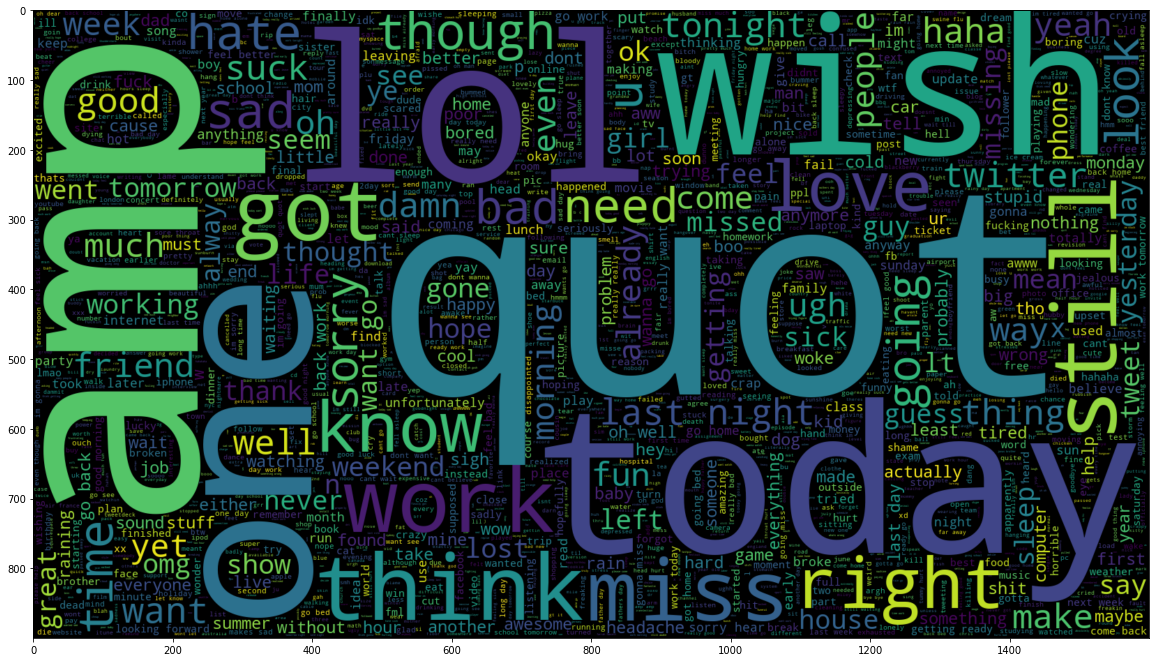

In [ ]:
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==0.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Preparing Data for Model Building
Tokenizing the Text

In [ ]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words_tokens")
words_tokens = tokenizer.transform(df)
words_tokens.show()

+-----+--------------------+--------------------+--------------------+
|label|                text|        text_cleaned|        words_tokens|
+-----+--------------------+--------------------+--------------------+
|  0.0|            At work |                work|              [work]|
|  0.0|@astewart87 oh my...|oh gosh made emot...|[oh, gosh, made, ...|
|  0.0|i need new glasse...|need new glasses ...|[need, new, glass...|
|  0.0|Getting changed i...|getting changed h...|[getting, changed...|
|  0.0|really now, time ...|really time sleep...|[really, time, sl...|
|  0.0|pfff i want to go...|pfff want go back...|[pfff, want, go, ...|
|  0.0|Currently watchin...|currently watchin...|[currently, watch...|
|  0.0|What a bad day! N...|bad day need comf...|[bad, day, need, ...|
|  0.0|Tried to install ...|tried install twi...|[tried, install, ...|
|  0.0|Having casual, un...|casual unprotecte...|[casual, unprotec...|
|  0.0|Good morning worl...|good morning worl...|[good, morning, w...|
|  0.0

### Applying CountVectorizer

In [ ]:
from pyspark.ml.feature import CountVectorizer
count = CountVectorizer (inputCol="words_tokens", outputCol="rawFeatures")
model = count.fit(words_tokens)
featurizedData = model.transform(words_tokens)
featurizedData.show()

+-----+--------------------+--------------------+--------------------+--------------------+
|label|                text|        text_cleaned|        words_tokens|         rawFeatures|
+-----+--------------------+--------------------+--------------------+--------------------+
|  0.0|            At work |                work|              [work]|  (262144,[7],[1.0])|
|  0.0|@astewart87 oh my...|oh gosh made emot...|[oh, gosh, made, ...|(262144,[2,26,30,...|
|  0.0|i need new glasse...|need new glasses ...|[need, new, glass...|(262144,[25,33,10...|
|  0.0|Getting changed i...|getting changed h...|[getting, changed...|(262144,[4,56,235...|
|  0.0|really now, time ...|really time sleep...|[really, time, sl...|(262144,[12,18,35...|
|  0.0|pfff i want to go...|pfff want go back...|[pfff, want, go, ...|(262144,[4,6,13,2...|
|  0.0|Currently watchin...|currently watchin...|[currently, watch...|(262144,[5,32,61,...|
|  0.0|What a bad day! N...|bad day need comf...|[bad, day, need, ...|(262144,[1

# Applying Term Frequency - Inverse Document Frequency (TF-IDF)

In [ ]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show()  

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262144,[7],[3.24...|
|  0.0|(262144,[2,26,30,...|
|  0.0|(262144,[25,33,10...|
|  0.0|(262144,[4,56,235...|
|  0.0|(262144,[12,18,35...|
|  0.0|(262144,[4,6,13,2...|
|  0.0|(262144,[5,32,61,...|
|  0.0|(262144,[1,33,48,...|
|  0.0|(262144,[7,39,121...|
|  0.0|(262144,[20,81,20...|
|  0.0|(262144,[0,10,35,...|
|  0.0|(262144,[24,39,40...|
|  0.0|(262144,[3,147,98...|
|  0.0|(262144,[15,49,29...|
|  0.0|(262144,[21,51,14...|
|  0.0|(262144,[8,31,78,...|
|  0.0|(262144,[66,201,3...|
|  0.0|(262144,[8,31,124...|
|  0.0|(262144,[157,256,...|
|  0.0|(262144,[176,317,...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
df_final = rescaledData.select("label", "features")# We want only the label and features columns for our machine learning models

Splitting the data into training and test dataset

In [ ]:
seed = 42  # set seed for reproducibility

trainDF, testDF = df_final.randomSplit([0.7,0.3],seed)

In [ ]:
trainDF.count()

1120318

In [ ]:
trainDF.show()

+-----+--------------+
|label|      features|
+-----+--------------+
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
|  0.0|(262144,[],[])|
+-----+--------------+
only showing top 20 rows



In [ ]:
trainDF.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|559900|
|  1.0|560418|
+-----+------+



In [ ]:
testDF.count()

479682

# Training the Model

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
lr = LogisticRegression(labelCol = "label", featuresCol = "features",maxIter = 10)
model = lr.fit(trainDF)

In [ ]:
predictions = model.transform(testDF)
pred = predictions.toPandas()
pred.head()

,label,features,rawPrediction,probability,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2770397840380635, 0.2770397840380635]","[0.43117966135128655, 0.5688203386487134]",1.0
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2770397840380635, 0.2770397840380635]","[0.43117966135128655, 0.5688203386487134]",1.0
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2770397840380635, 0.2770397840380635]","[0.43117966135128655, 0.5688203386487134]",1.0
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2770397840380635, 0.2770397840380635]","[0.43117966135128655, 0.5688203386487134]",1.0
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2770397840380635, 0.2770397840380635]","[0.43117966135128655, 0.5688203386487134]",1.0


# Evaluating the Model

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = "label", metricName='areaUnderROC')

In [ ]:
areaUnderROC = evaluator.evaluate(predictions)
print(f"The testing areaUnderROC of our Logistic Regression model is: {areaUnderROC}")

The testing areaUnderROC of our Logistic Regression model is: 0.8182434020576255


**Classification Report and Confusion Matrix**

In [ ]:
y_true = pred['label'].astype('float')
y_pred = pred['prediction']

In [ ]:
y_true.value_counts()

0.0    240100
1.0    239582
Name: label, dtype: int64

In [ ]:
y_pred.value_counts()

1.0    247756
0.0    231926
Name: prediction, dtype: int64

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76    240100
         1.0       0.75      0.78      0.76    239582

    accuracy                           0.76    479682
   macro avg       0.76      0.76      0.76    479682
weighted avg       0.76      0.76      0.76    479682



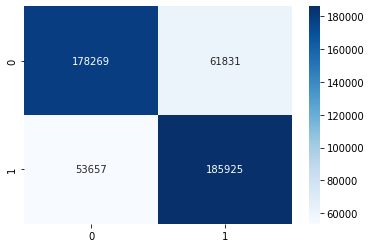

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt=  'd', cmap = 'Blues')